# Notes

This notebook inspects the data in diabetes_012_health_indicators_BRFSS2015.csv

It gives a high level description of the data and visualises the distribution of each feature

It runs a decision tree on the data split into test and train data

The results show the decision tree does not perform well in the out of sample data

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Data Locations:

In [58]:
dataroot = Path("/Users/darja/Desktop/University23_24/1semester/MODULE_IN3062_Introduction_to_Artificial_Intelligence/coursework/archive_dataset_we_using")
file1 = "diabetes_012_health_indicators_BRFSS2015.csv"  # 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes
file2 = "diabetes_binary_health_indicators_BRFSS2015.csv"  # 0 is for no diabetes, and 1 is for prediabetes or diabetes
file3 = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv" #  0 is for no diabetes, and 1 is for prediabetes or diabetes. balanced

## Load the data

In [59]:
data_1 = pd.read_csv(dataroot / file1)
data_2 = pd.read_csv(dataroot / file2)
data_3 = pd.read_csv(dataroot / file3)

# Data Description

We have data with 22 columns.
- The columns are all potential predictors of a persons diabetes status.
- The status consists of 3 possibilities: 0 (no diabetes), 1 (pre diabetes), 2 (has diabetes)

In [60]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [61]:
# name the dependent variable or target
dependent_variable = "Diabetes_012"

The data types consist of two main feature types: binary (0 or 1 -> yes or no), and continuous values (e.g BMI)

In [62]:
data_1.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


The below features are categorical, and in this case, binary features. I.e they are yes or no:

In [63]:
is_binary = data_1.drop(dependent_variable, axis=1).nunique() == 2
is_binary = list(is_binary[is_binary].index)
is_binary

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'DiffWalk',
 'Sex']

The below have multiple values.
Most contain discrete values with a defined upper bound but all lend themselves to interpolation or a regression - > i.e increasing values mean 'more' or 'less' of the trait:

In [64]:
is_mult = data_1.drop(dependent_variable, axis=1).nunique() > 2
is_mult = list(is_mult[is_mult].index)
is_mult

['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

In [65]:
data_1.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


There are no nans or infs:

In [66]:
data_1.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [67]:
(data_1 == data_1).sum()  # inf doesn't equal inf so this would detect them

Diabetes_012            253680
HighBP                  253680
HighChol                253680
CholCheck               253680
BMI                     253680
Smoker                  253680
Stroke                  253680
HeartDiseaseorAttack    253680
PhysActivity            253680
Fruits                  253680
Veggies                 253680
HvyAlcoholConsump       253680
AnyHealthcare           253680
NoDocbcCost             253680
GenHlth                 253680
MentHlth                253680
PhysHlth                253680
DiffWalk                253680
Sex                     253680
Age                     253680
Education               253680
Income                  253680
dtype: int64

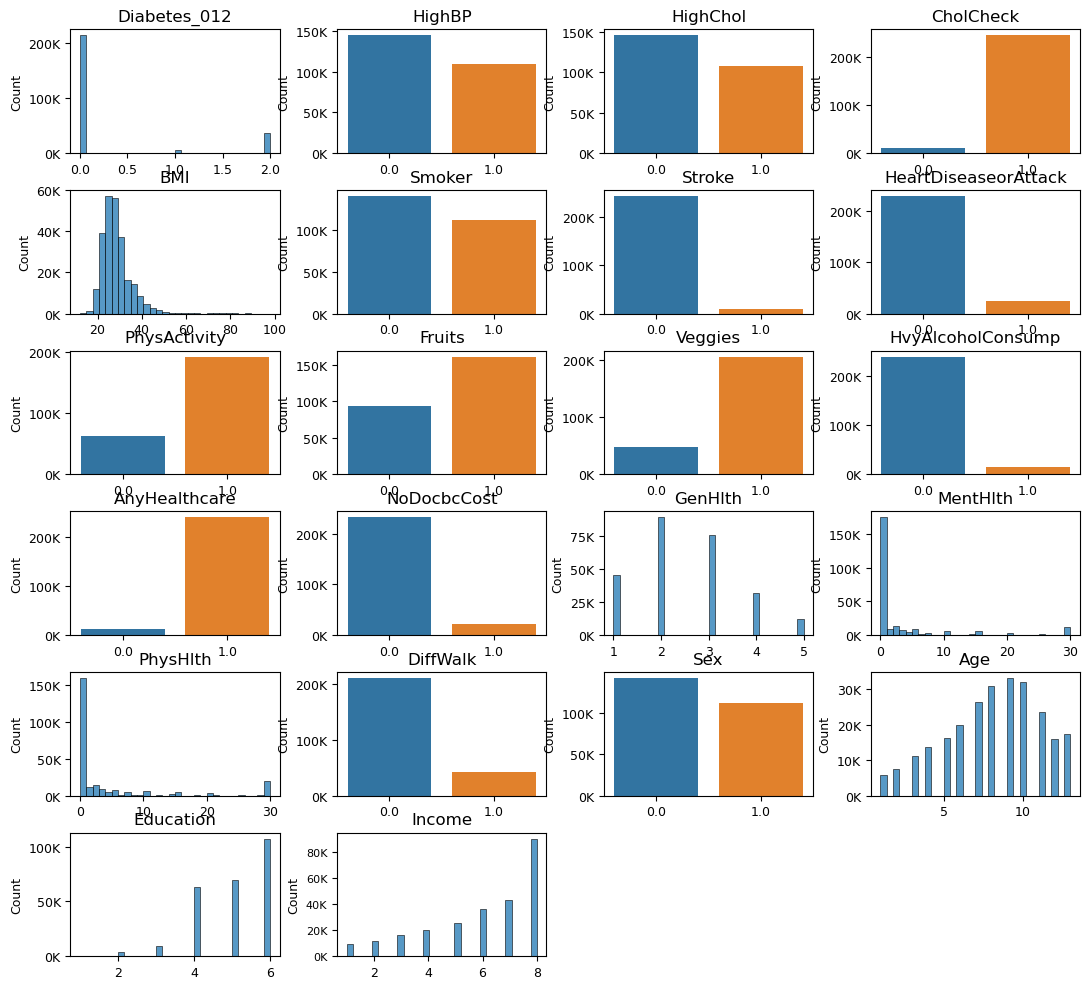

In [68]:
# Check distributions
def plot_distributions(df, subplot_columns=4):
    num_columns = df.shape[1]  # number of features

    subplot_rows = int(np.ceil(num_columns/subplot_columns))
    
    fig, ax = plt.subplots(subplot_rows, subplot_columns, figsize=(11, 10))

    # Create a formatter to show multiples of a thousand for the y axis labels
    def thousand_format(y, pos):
        return f"{y / 1000:.0f}K"
        
    for i, column in enumerate(df.columns):
        if column in is_binary:
            # Use a count plot for binary features
            sns.countplot(x=column, data=df, ax=ax[int(np.floor(i / subplot_columns))][i % subplot_columns])
        else:
            # Histogram for continuous features
            sns.histplot(df[column], bins=30, ax=ax[int(np.floor(i / subplot_columns))][i % subplot_columns])

        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].set_ylabel('Count',fontsize=9)
        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].set_title(f'{column}', fontsize=12)
        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].set_xlabel(f'')
        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].tick_params(axis='y', labelsize=9)
        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].tick_params(axis='x', labelsize=9)
        ax[int(np.floor(i / subplot_columns))][i % subplot_columns].yaxis.set_major_formatter(ticker.FuncFormatter(thousand_format))

    # remove any unused plots:
    remaining = (subplot_columns * subplot_rows) - i - 1
    for r in range(-remaining, 0, 1):
        ax[subplot_rows - 1][r].remove()

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.275, hspace=0.3)
    plt.tick_params(axis='y', labelsize=8)
    plt.show()

plot_distributions(data_1)


## Set up a decision tree model

In [69]:
seed = 10  # so results can be repeated

In [70]:
# Separate data so some is used for training, the rest or used for testing
dependent_variable = "Diabetes_012"
X = data_1.drop(dependent_variable, axis=1)  # predictors
y = data_1[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [71]:
# Set up the decision tree classifier and fit
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

# Analysing Results

- Accuracy shows the percentage of predictions that were correct
- Precision is the percentage of predictions for a particular classification that are correct (TP/TP+FP)
- Recall is the percentage of a particular classification that was predicted correctly (TP/TP+FN)
- F1-Score is the harmonic mean of precision and recall. It's a balance of the two
- Support is the count of samples for that category

In [72]:
# Check in sample results

y_pred = clf.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
report = classification_report(y_train, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report


Accuracy: 0.9932838615578682


,precision,recall,f1-score,support
0.0,0.992395,0.999842,0.996105,171100.000000
1.0,0.993449,0.941176,0.966607,3706.000000
2.0,0.998928,0.960267,0.979216,28138.000000
accuracy,0.993284,0.993284,0.993284,0.993284
macro avg,0.994924,0.967095,0.980642,202944.000000
weighted avg,0.993320,0.993284,0.993224,202944.000000


In [73]:
# Check out of sample results

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report


Accuracy: 0.765964995269631


,precision,recall,f1-score,support
0.0,0.872981,0.859047,0.865958,42603.000000
1.0,0.027615,0.035676,0.031132,925.000000
2.0,0.292859,0.309517,0.300958,7208.000000
accuracy,0.765965,0.765965,0.765965,0.765965
macro avg,0.397818,0.401413,0.399349,50736.000000
weighted avg,0.775152,0.765965,0.770469,50736.000000


## Comment on results

The model is not suitable and overfits the data. The insample results show excellent precision and recall, while the out of sample shows very low precision for pre diabetic and diabetic categories (3% and 30% respectively)

Overal accuracy is inflated because the data is unbalanced. There are many cases of non diabetics which is easier for the model to predict.

# Confusion Matrix

In [74]:
cm = confusion_matrix(y_test, y_pred)


pd.DataFrame(cm, columns=["Predicted Non Diabetic", "Predicted Pre Diabetic", "Predicted Diabetic"], 
             index=["Actual Non Diabetic", "Actual Pre Diabetic", "Actual Diabetic"])

,Predicted Non Diabetic,Predicted Pre Diabetic,Predicted Diabetic
Actual Non Diabetic,36598,878,5127
Actual Pre Diabetic,632,33,260
Actual Diabetic,4693,284,2231


# Repeat above for the other two datasets:
- These are for binary classification only so we change the dependent variable

In [75]:
dependent_variable = "Diabetes_binary"

In [76]:
# Separate data so some is used for training, the rest or used for testing
X = data_2.drop(dependent_variable, axis=1)  # predictors
y = data_2[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [77]:
# Set up the decision tree classifier and fit
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [78]:
# Check in sample results

y_pred = clf.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))


Accuracy: 0.9943481945758436
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    174806
         1.0       1.00      0.96      0.98     28138

    accuracy                           0.99    202944
   macro avg       1.00      0.98      0.99    202944
weighted avg       0.99      0.99      0.99    202944



In [79]:
report = classification_report(y_train, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.993644,0.999834,0.996729,174806.000000
1.0,0.998928,0.960267,0.979216,28138.000000
accuracy,0.994348,0.994348,0.994348,0.994348
macro avg,0.996286,0.980051,0.987973,202944.000000
weighted avg,0.994377,0.994348,0.994301,202944.000000


In [80]:
# Check out of sample results

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7961999369284137
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.88     43528
         1.0       0.30      0.32      0.31      7208

    accuracy                           0.80     50736
   macro avg       0.59      0.60      0.59     50736
weighted avg       0.80      0.80      0.80     50736



In [81]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.885781,0.875322,0.880520,43528.0000
1.0,0.297203,0.318396,0.307435,7208.0000
accuracy,0.796200,0.796200,0.796200,0.7962
macro avg,0.591492,0.596859,0.593978,50736.0000
weighted avg,0.802163,0.796200,0.799103,50736.0000


# Results:
The results are similar to the multiclassification data with only around 30% precision and recall for 'Non diabetic' and 'Diabetic'

# Binary data set with balanced data:

In [82]:
# Separate data so some is used for training, the rest or used for testing
dependent_variable = "Diabetes_binary"
X = data_3.drop(dependent_variable, axis=1)  # predictors
y = data_3[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [83]:
# Set up the decision tree classifier and fit
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

In [84]:
# Check in sample results

y_pred = clf.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))


Accuracy: 0.99510193977331
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     28308
         1.0       1.00      0.99      1.00     28245

    accuracy                           1.00     56553
   macro avg       1.00      1.00      1.00     56553
weighted avg       1.00      1.00      1.00     56553



In [85]:
report = classification_report(y_train, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.990790,0.999505,0.995129,28308.000000
1.0,0.999500,0.990689,0.995075,28245.000000
accuracy,0.995102,0.995102,0.995102,0.995102
macro avg,0.995145,0.995097,0.995102,56553.000000
weighted avg,0.995140,0.995102,0.995102,56553.000000


In [86]:
# Check out of sample results

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6514604993280996
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      7038
         1.0       0.66      0.64      0.65      7101

    accuracy                           0.65     14139
   macro avg       0.65      0.65      0.65     14139
weighted avg       0.65      0.65      0.65     14139



In [87]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.646487,0.661552,0.653933,7038.00000
1.0,0.656624,0.641459,0.648953,7101.00000
accuracy,0.651460,0.651460,0.651460,0.65146
macro avg,0.651555,0.651505,0.651443,14139.00000
weighted avg,0.651578,0.651460,0.651432,14139.00000


The results show more balanced results between no diabetes and diabetes. The balanced data has resulted in more equal weight being given to each category

# Test balanced model on unbalanced data:

In [88]:
# Get the training data from the balanced data and remove it from the balanced data so there is no in sample in the result
dependent_variable = "Diabetes_binary"
X = data_3  # all data
y = data_3[dependent_variable]  # dependent variable
data_3_X_train, _, _, _ = train_test_split(X, y, test_size=0.2, random_state=seed)


In [89]:
merged_data = pd.merge(data_2, data_3_X_train, how="outer", left_index=False, right_index=False, on=None, indicator=True)

In [90]:
data_2_oos = merged_data.loc[(merged_data["_merge"] == "left_only")]
data_2_oos = data_2_oos.drop('_merge', axis=1)
X = data_2_oos.drop(dependent_variable, axis=1)  # predictors
y = data_2_oos[dependent_variable]  # dependent variable

In [91]:
# Check Results
y_pred = clf.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

Accuracy: 0.6383484826469052
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.64      0.77    178818
         1.0       0.06      0.64      0.12      6999

    accuracy                           0.64    185817
   macro avg       0.52      0.64      0.44    185817
weighted avg       0.94      0.64      0.75    185817



In [92]:
report = classification_report(y, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.978283,0.638364,0.772588,178818.000000
1.0,0.064587,0.637948,0.117298,6999.000000
accuracy,0.638348,0.638348,0.638348,0.638348
macro avg,0.521435,0.638156,0.444943,185817.000000
weighted avg,0.943868,0.638348,0.747906,185817.000000


# Random Forest Model
- This may help with overfitting issue seen in the decision tree model
- First, again on the diabetes_012 data

In [93]:
# Separate data so some is used for training, the rest or used for testing
dependent_variable = "Diabetes_012"
X = data_1.drop(dependent_variable, axis=1)  # predictors
y = data_1[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [94]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=10)

In [95]:
# Check Results - ins
y_pred = rf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))


Accuracy: 0.9927714049195837
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    171100
         1.0       0.99      0.93      0.96      3706
         2.0       0.99      0.96      0.98     28138

    accuracy                           0.99    202944
   macro avg       0.99      0.97      0.98    202944
weighted avg       0.99      0.99      0.99    202944



In [96]:
# Check Results - oos
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8379060233364869
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     42603
         1.0       0.03      0.00      0.00       925
         2.0       0.48      0.20      0.28      7208

    accuracy                           0.84     50736
   macro avg       0.46      0.39      0.40     50736
weighted avg       0.79      0.84      0.80     50736



In [97]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.861682,0.964369,0.910138,42603.000000
1.0,0.034483,0.002162,0.004069,925.000000
2.0,0.475317,0.197697,0.279248,7208.000000
accuracy,0.837906,0.837906,0.837906,0.837906
macro avg,0.457161,0.388076,0.397818,50736.000000
weighted avg,0.791710,0.837906,0.803989,50736.000000


# Binary data, unbalanced:

In [98]:
# Separate data so some is used for training, the rest or used for testing
dependent_variable = "Diabetes_binary"
X = data_2.drop(dependent_variable, axis=1)  # predictors
y = data_2[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [99]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=10)

In [100]:
# Check Results - ins
y_pred = rf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))


Accuracy: 0.9939293598233996
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    174806
         1.0       0.99      0.96      0.98     28138

    accuracy                           0.99    202944
   macro avg       0.99      0.98      0.99    202944
weighted avg       0.99      0.99      0.99    202944



In [101]:
# Check Results - oos
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.856019394512772
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43528
         1.0       0.48      0.17      0.25      7208

    accuracy                           0.86     50736
   macro avg       0.68      0.57      0.59     50736
weighted avg       0.82      0.86      0.83     50736



In [102]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.876171,0.969146,0.920316,43528.000000
1.0,0.481267,0.172863,0.254364,7208.000000
accuracy,0.856019,0.856019,0.856019,0.856019
macro avg,0.678719,0.571005,0.587340,50736.000000
weighted avg,0.820067,0.856019,0.825705,50736.000000


# Binary data, balanced:

In [103]:
# Separate data so some is used for training, the rest or used for testing
dependent_variable = "Diabetes_binary"
X = data_3.drop(dependent_variable, axis=1)  # predictors
y = data_3[dependent_variable]  # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [104]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=10)

In [105]:
# Check Results - ins
y_pred = rf.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))


Accuracy: 0.9948367018548971
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     28308
         1.0       1.00      0.99      0.99     28245

    accuracy                           0.99     56553
   macro avg       0.99      0.99      0.99     56553
weighted avg       0.99      0.99      0.99     56553



In [106]:
# Check Results - oos
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7327958129995049
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.70      0.72      7038
         1.0       0.72      0.77      0.74      7101

    accuracy                           0.73     14139
   macro avg       0.73      0.73      0.73     14139
weighted avg       0.73      0.73      0.73     14139



In [107]:
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.747269,0.699915,0.722817,7038.000000
1.0,0.720154,0.765385,0.742081,7101.000000
accuracy,0.732796,0.732796,0.732796,0.732796
macro avg,0.733712,0.732650,0.732449,14139.000000
weighted avg,0.733651,0.732796,0.732492,14139.000000


# Balanced model on unbalanced data:

In [108]:
# Get the training data from the balanced data and remove it from the balanced data so there is no in sample in the result
dependent_variable = "Diabetes_binary"
X = data_3  # all data
y = data_3[dependent_variable]  # dependent variable
data_3_X_train, _, _, _ = train_test_split(X, y, test_size=0.2, random_state=seed)


In [109]:
merged_data = pd.merge(data_2, data_3_X_train, how="outer", left_index=False, right_index=False, on=None, indicator=True)

In [110]:
data_2_oos = merged_data.loc[(merged_data["_merge"] == "left_only")]
data_2_oos = data_2_oos.drop('_merge', axis=1)
X = data_2_oos.drop(dependent_variable, axis=1)  # predictors
y = data_2_oos[dependent_variable]  # dependent variable

In [111]:
# Check Results
y_pred = rf.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))


Accuracy: 0.6843884036444459
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.68      0.81    178818
         1.0       0.09      0.76      0.15      6999

    accuracy                           0.68    185817
   macro avg       0.54      0.72      0.48    185817
weighted avg       0.95      0.68      0.78    185817



In [112]:
report = classification_report(y, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0.0,0.986589,0.681296,0.806002,178818.000000
1.0,0.085717,0.763395,0.154128,6999.000000
accuracy,0.684388,0.684388,0.684388,0.684388
macro avg,0.536153,0.722345,0.480065,185817.000000
weighted avg,0.952657,0.684388,0.781448,185817.000000
